In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from math import ceil
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('../utils/')
from data_utils import get_image_folders
from train_utils import train
from diagnostic_tools import count_params
    
torch.cuda.is_available()

True

In [3]:
torch.backends.cudnn.benchmark = True

# Create data iterators

In [4]:
batch_size = 256

In [5]:
train_folder, val_folder = get_image_folders()

train_iterator = DataLoader(
    train_folder, batch_size=batch_size, num_workers=4,
    shuffle=True, pin_memory=True
)

val_iterator = DataLoader(
    val_folder, batch_size=256, num_workers=4,
    shuffle=False, pin_memory=True
)

# number of training samples
train_size = len(train_folder.imgs)
train_size

100000

In [6]:
# number of validation samples
val_size = len(val_folder.imgs)
val_size

10000

# Model

In [7]:
from get_squeezenet import get_model

In [8]:
model, criterion, optimizer = get_model()

In [9]:
# number of params in the model
count_params(model)

827784

# Train

In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

n_epochs = 200
n_batches = ceil(train_size/batch_size)

lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='max', factor=0.1, patience=4, 
    verbose=True, threshold=0.01, threshold_mode='abs'
)

# total number of batches in the train set
n_batches

391

In [11]:
%%time
all_losses = train(
    model, criterion, optimizer,
    train_iterator, n_epochs, steps_per_epoch=n_batches,
    val_iterator=val_iterator, n_validation_batches=40,
    patience=8, threshold=0.01, # early stopping
    lr_scheduler=lr_scheduler
)
# epoch logloss  accuracy    top5_accuracy time  (first value: train, second value: val)

0  4.773 4.193  0.055 0.120  0.168 0.311  38.826
1  3.972 3.703  0.144 0.186  0.357 0.420  37.584
2  3.633 3.400  0.198 0.236  0.439 0.490  37.458
3  3.415 3.201  0.234 0.263  0.488 0.537  37.559
4  3.246 3.166  0.262 0.280  0.527 0.539  37.823
5  3.112 3.010  0.289 0.299  0.553 0.575  37.762
6  3.011 2.970  0.307 0.315  0.577 0.587  37.702
7  2.920 2.831  0.322 0.335  0.595 0.615  37.724
8  2.845 2.837  0.337 0.339  0.610 0.616  37.622
9  2.774 2.698  0.351 0.365  0.623 0.641  37.459
10  2.714 2.627  0.362 0.376  0.635 0.655  37.561
11  2.656 2.651  0.373 0.367  0.648 0.649  37.356
12  2.602 2.598  0.383 0.382  0.658 0.660  37.828
13  2.557 2.603  0.393 0.388  0.667 0.661  37.479
14  2.518 2.505  0.399 0.404  0.674 0.678  37.536
15  2.473 2.489  0.410 0.409  0.682 0.678  37.703
16  2.438 2.507  0.418 0.403  0.690 0.677  37.607
17  2.412 2.480  0.419 0.412  0.695 0.689  37.643
18  2.384 2.472  0.427 0.412  0.699 0.686  37.400
19  2.351 2.432  0.433 0.419  0.706 0.696  37.992
20  2.324 

# Loss/epoch plots

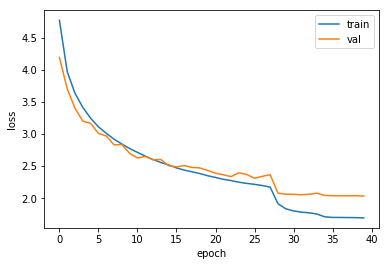

In [12]:
epochs = [x[0] for x in all_losses]
plt.plot(epochs, [x[1] for x in all_losses], label='train');
plt.plot(epochs, [x[2] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('loss');

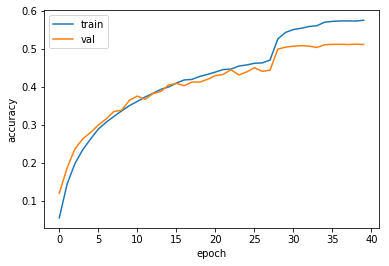

In [13]:
plt.plot(epochs, [x[3] for x in all_losses], label='train');
plt.plot(epochs, [x[4] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('accuracy');

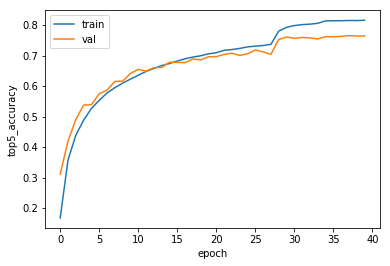

In [14]:
plt.plot(epochs, [x[5] for x in all_losses], label='train');
plt.plot(epochs, [x[6] for x in all_losses], label='val');
plt.legend();
plt.xlabel('epoch');
plt.ylabel('top5_accuracy');

# Save

In [15]:
model.cpu();
torch.save(model.state_dict(), 'model.pytorch_state')